# めちゃめちゃ参考文献

https://www.youtube.com/@user-ej3zj6kv9z

そーすこーどとかほぼパクリなので, 使用の際は気を付けて

# import

In [3]:
%load_ext autoreload
import pandas as pd
from tqdm.notebook import tqdm 
from graphviz import *
import lightgbm as lgb
import pickle
from my_modules.constants import LocalPaths,Master
from my_modules import prepare,funcs,preprocess,simulator,training
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  データロード ※更新2023/02/02

In [4]:
race_results = pd.read_csv(LocalPaths.RESULTS_PATH,index_col=0)
horse_results = pd.read_csv(LocalPaths.HORSE_RESULTS_PATH,index_col=0)
peds = pd.read_csv(LocalPaths.PEDS_PATH,index_col=0)
peds.fillna('nan',inplace=True) # 何回やってもロードすると, nanが出る
return_tables = pd.read_csv(LocalPaths.RETURN_PATH,index_col=0)
return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)# 毎回読み込むごとに, strに変換されてしまう

# データ収集

In [7]:
# toの月は含まないので注意
kaisai_date_list = prepare.scrape_kaisai_date(from_="2023-01-01",to_='2023-02-01')

getting race date from 2023-01-01 to 2023-02-01


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


In [ ]:
race_id_list = prepare.scrape_race_id_list(kaisai_date_list)

In [35]:
# データ収集
new_return_tables = prepare.scrape_return_tables(race_id_list)
# データ更新
return_tables = pd.read_csv(LocalPaths.RETURN_PATH,index_col=0)
return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)
new_return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)
update_return_tables = funcs.update_data(return_tables,new_return_tables)
update_return_tables.to_csv(LocalPaths.RETURN_PATH)


In [61]:
# データ収集
new_race_results = prepare.scrape_race_results(race_id_list)
# データ更新
race__results = pd.read_csv(LocalPaths.RESULTS_PATH,index_col=0)
update_race_results = funcs.update_data(race_results,new_race_results)
update_race_results.to_csv(LocalPaths.RESULTS_PATH)

In [62]:
# データ収集
horse_id_list = new_race_results['horse_id'].unique()
new_horse_results = prepare.scrape_horse_results(horse_id_list)
# データ更新
horse_results = pd.read_csv(LocalPaths.HORSE_RESULTS_PATH,index_col=0)
update_horse_results = funcs.update_data(horse_results,new_horse_results)
update_horse_results.to_csv(LocalPaths.HORSE_RESULTS_PATH)

In [63]:
# データ収集
new_peds = prepare.scrape_peds(horse_id_list)
# データ更新
peds = pd.read_csv(LocalPaths.PEDS_PATH,index_col=0)
update_peds = funcs.update_data(peds,new_peds)
update_peds.to_csv(LocalPaths.PEDS_PATH)

# データ形式

### データ　見た目こんな感じ

## race_results ※更新
trainer_id, owner_id を追加
過去のcsvファイルと異なるので, 注意

In [4]:
"""
    レース結果を記録したテーブル
    results.index : Int64Index, index は race_id
    index だけでは一意にレコードが求まらないので, 注意
"""
race_results.head() # index : race_id

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,...,調教師,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,trainer_id,owner_id
202306010101,1,7,14,シュバルツガイスト,牡3,56,武豊,1:12.6,NaN,1.8,...,[東] 国枝栄,1200,晴,ダート,良,2023年1月5日,2020103575,666,399,356803
202306010101,2,3,5,ジェイケイファイン,牡3,56,内田博幸,1:12.9,1.3/4,7.4,...,[東] 奥平雅士,1200,晴,ダート,良,2023年1月5日,2020107073,422,1074,702009
202306010101,3,1,1,レディアス,牝3,54,津村明秀,1:12.9,クビ,36.1,...,[東] 鈴木慎太,1200,晴,ダート,良,2023年1月5日,2020102562,1092,1179,763033
202306010101,4,8,15,ハローマイラブリー,牝3,54,三浦皇成,1:13.4,3,4.2,...,[東] 伊坂重信,1200,晴,ダート,良,2023年1月5日,2020106345,1122,1177,729005
202306010101,5,5,9,ベアカワイコチャン,牝3,54,松岡正海,1:13.9,3,7.9,...,[東] 杉浦宏昭,1200,晴,ダート,良,2023年1月5日,2020100039,1085,1008,372033


In [7]:
""" 
    馬の過去の全戦績を記したテーブル
    horse_results.index : Int64Index, index は horse_id
    indexはhorse_id
    こちらも, index だけでは一意にレコードが定まらないので注意
"""
horse_results.head()

,日付,開催,天気,R,レース名,映像,頭数,枠番,馬番,オッズ,...,着差,ﾀｲﾑ指数,通過,ペース,上り,馬体重,厩舎ｺﾒﾝﾄ,備考,勝ち馬(2着馬),賞金
2017105800,2021/07/08,名古屋,曇,7.0,C12組,NaN,10.0,4.0,4.0,6.6,...,NaN,**,4-3,0.0-39.5,NaN,479(-1),NaN,NaN,ナツミフルーリー,NaN
2017105800,2021/06/30,名古屋,曇,5.0,C14組,NaN,10.0,3.0,3.0,12.2,...,0.7,**,5-6-5,0.0-40.3,39.4,480(-4),NaN,NaN,マルカブレーブ,10.2
2017105800,2021/06/16,名古屋,雨,5.0,美穂ちゃんバースデイ,NaN,11.0,2.0,2.0,13.5,...,2.7,**,10-10-8,0.0-38.2,38.4,484(+3),NaN,NaN,タイキスピネル,2.6
2017105800,2021/06/03,名古屋,晴,6.0,C14組,NaN,10.0,8.0,9.0,3.8,...,1.0,**,3-4-4,0.0-39.6,40.1,481(-6),NaN,NaN,トーホウボッカ,NaN
2017105800,2021/05/19,名古屋,雨,5.0,C15組,NaN,11.0,8.0,11.0,29.8,...,0.5,**,3-3-3,0.0-38.4,38.6,487(0),NaN,NaN,キングリアリティー,10.2


In [8]:
""" 
    馬の血統データ
    peds.index : Int64Index, index は horse_id
    カタカナ, 英字が混じっているので, 注意
"""
peds.head() # 5世代分の血統データ

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2017100590,クロフネ,ハッピーティア,フレンチデピュティ,ブルーアヴェニュー,ホワイトマズル,ハッピーチケット,DeputyMinister,Mitterand,ClassicGoGo,ElizaBlue,...,Tyrant,FlightTable,Halo,WishingWell,Lyphard,Prodice,Herbager,SilverCoin,チャイナロック,ソシアルバターフライ
2017106441,スピルバーグ,ミュージー,ディープインパクト,プリンセスオリビア,ElPrado,Foible,サンデーサイレンス,ウインドインハーヘア,Lycius,DanceImage,...,TomFool,Ghazni,Nasrullah,Lalun,PrinceJohn,NileLily,Turnto,YourGame,RestlessNative,EnchantedEve
2017106225,ケープブランコ,ヒラボクキャロル,Galileo,LaurelDelight,ダンスインザダーク,チョウカイキャロル,SadlersWells,アーバンシー,Presidium,Foudroyer,...,KeytotheMint,NativePartner,HailtoReason,Bramalea,Graustark,GoldenTrail,RaiseaNative,GoldDigger,VaguelyNoble,SleekDancer
2014105693,キンシャサノキセキ,マイワイルドローズ,フジキセキ,ケルトシャーン,WildAgain,RoseofMull,サンデーサイレンス,ミルレーサー,PleasantColony,Featherhill,...,Dante,Clovelly,SwordDancer,Kerala,Buckpasser,Intriguing,Ribot,Pocahontas,DarkStar,Vulcania
2013101632,メイショウサムソン,シルクヴァルキリー,オペラハウス,マイヴィヴィアン,マーベラスサンデー,シルクフレアー,SadlersWells,Colorspin,ダンシングブレーヴ,ウイルプリンセス,...,LaughAloud,HoldMeClose,Nearctic,Natalma,AdmiralsVoyage,Petitioner,RaiseaNative,SweetTooth,ノノアルコ,Mortefontaine


In [12]:
""" 
    return_tables レースの払い戻し金額が記されたテーブル
    return_tables.index : Int64Index, index は race_id
    こちらも, index では一意にレコードが定まらない
    カラムの
        0 : 払い戻し種別
        1 : 馬番, 
            ex) 6 なら 馬番6が払い戻し対象
        2 : 払い戻し金額 (単位 : 円, 100円賭けた時の払い戻し金額), 
            ex) 複勝で カラム(2) が 490br130 なら, 馬番6の払い戻しが 490円 馬番2が130円
        3 : 多分人気度を表してる, 使ってないから dont care
"""
return_tables.head()

,0,1,2,3
202001010101,単勝,6,1600,3
202001010101,複勝,6br2,490br130,4br2
202001010101,馬連,2 - 6,1410,4
202001010101,ワイド,2 - 6br3 - 6br2 - 3,150br170br110,3br4br1
202001010101,馬単,6 → 2,3920,9


# データ前処理

In [40]:
%autoreload

In [41]:
race_results_processor = preprocess.RaceResults(race_results)
horse_results_processor = preprocess.HorseResults(horse_results)
peds_processor = preprocess.Peds(peds) # <= 結構時間かかる

race_results_processor.preprocessing()
horse_results_processor.preprocessing()
peds_processor.preprocessing()



finish regularize


# データマージ

In [43]:
%autoreload

In [44]:
data_merger = preprocess.DataMerger(
    race_results_processor,
    horse_results_processor,
    peds_processor
)

data_merger.merge()
# no peds list が出力されたら, 該当のhorse_idをscrapeしなおした方が良い

# 学習データ作成

In [59]:
%autoreload

In [60]:
make_train_data = preprocess.MakeTrainData(data_merger)
# ----- 特徴量は, メソッド形式で追加
make_train_data.categorize_id()
make_train_data.categorize_peds()
make_train_data.dumminize() 
make_train_data.add_date_cosin()
processed_df = make_train_data.get_processed_df()


--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--


# 正解ラベルの変更, 訓練,テスト スプリット

In [64]:
%autoreload

In [145]:
# 正解ラベルの変更
# rank学習は, 上位に予測したいラベルに重み付けをする

"""
    label_type : 'bin' => 上位3着が 1, それ以外が 0
    label_type : 'bias_top3' => 上位3着 [10,5,3] それ以外は0
    label_type : 'bias_all' => [10,5,3,2,2,1,1,....,0]
"""
processed_df = funcs.change_answer_label(processed_df,label_type='bias_top3')
x_train,y_train,x_test,y_test = funcs.make_data(processed_df,test_size=0.3)

In [14]:
x_train.head()

,枠番,馬番,斤量,course_len,horse_id,jockey_id,trainer_id,owner_id,年齢,体重,...,開催_06,開催_07,開催_10,開催_05,開催_04,開催_08,開催_09,開催_01,開催_03,開催_02
202008010103,7,13,54.0,14.0,5602,6,175,902,3,462,...,0,0,0,0,0,1,0,0,0,0
202008010103,5,10,53.0,14.0,4230,121,128,522,3,494,...,0,0,0,0,0,1,0,0,0,0
202008010103,4,8,54.0,14.0,4537,21,182,302,3,494,...,0,0,0,0,0,1,0,0,0,0
202008010103,1,1,54.0,14.0,6040,23,1,1239,3,486,...,0,0,0,0,0,1,0,0,0,0
202008010103,3,6,54.0,14.0,7100,155,83,33,3,450,...,0,0,0,0,0,1,0,0,0,0


In [146]:
y_train.head()

202008010103    10
202008010103     5
202008010103     3
202008010103     0
202008010103     0
Name: rank, dtype: int64

# rank学習の時の訓練のデータセット
訓練だけ, このような形式 <br>
予測は　x_train の形式で良い

In [147]:
train_query = x_train.groupby(x_train.index).size()
test_query = x_test.groupby(x_test.index).size()
train = lgb.Dataset(x_train, y_train, group=train_query)
test = lgb.Dataset(x_test, y_test, reference=train, group=test_query)

# ランク学習

### 主なパラメタ

In [ ]:

"""
1 "label_gain" : hp.choice('label_gain',range(1,2)),
    例えば3位までのランキングを学習する場合
    は1位のgainは3, 2位のgainは1, 3位のgainは0となることがわかります。
    もし、1位のgainを大きくしたい場合はlabel_gain="0,1,5"などと設定することで
    目的関数に対する順位の影響を操作することができるよ
    うになっています。

2 n_estimators == num_iterations==num_boost_round
    default = 100
    0 <= numiterations 

3 num_leaves
    1 <= num_leaves <= 131072
    default = 31
    大きいほど過学習寄り

4 'lambdarank_truncation_level'
    default = 20
    ラムダの計算をいくつのサンプルまで使用するかを決めるパラメータのようです。LightGBMで最適化するには、
    損失関数の1階微分(ラムダ)と2階微分がレコード毎に必要になります。
    同じクエリ内の全てのペアで関連度が上位の対象から計算されたラムダと、下位の対象のラムダの差分を計算する過程で、
    いくつまでのペアを使用するか指定するパラメータのようです。

5 'min_child_samples'
    default = 20
    1枚の葉に含まれる最小データ数(小さいほど過学習寄り)

6 ' feature_fraction' == 'colsample_bytree'
    ランダムに選択する特徴量の割合

7 'reg_alpha'(scikit-learn api) == 'lambda_l1'(training api)
    l1 正則化項の係数, 小さいほど過学習寄り
    float 0 ~ 10**7
    
8 'reg_lambda' == 'lambda_l2'

9 'subsample' == 'bagging_fraction'
    各決定木においてランダムに抽出されるサンプルの割合
    大きいほど過学習寄り
    default = 1

10 'subsample_freq' == 'bagging_freq'
    ここで指定したイテレーション事に bagging を実施
    int 0 ~ 10**7
    大きいほど過学習寄り, 0 の場合は bagging されない

※ --------  bagging とは ---------
    独立に多数の弱学習機を作って多数決をとったものを出力とするような手法のこと


"""

### 学習

In [148]:
base_params = {
        'metric': 'ndcg',          # 評価指標  
        'objective': 'lambdarank', # ランク学習
        'ndcg_eval_at': [1,2,3],   # 上位3着を考慮
        'boosting_type': 'gbdt',   # gradient based dicision tree
        'random_state': 777,       # 乱数 seed 固定
        'force_col_wise':True,     # cpu だとメモリ効率が良くなるらしい
        'verbosity':-1             # マイナスで, 非表示
            }

# ------------注意事項------------
#  valid_set 入れていると, 1本目の木作成時に過学習扱いされて, そこで学習停止してしまうので注意
#  valid_set は grid search の時だけでいい?

lgb_rank = lgb.train(
    base_params,
    train,
    # valid_sets=test,          <= 例によって使わない
    # valid_names=['valid'],
    # early_stopping_rounds=100,
    )

In [235]:
print("num_trees    :",lgb_rank.num_trees())
print("num_features :",lgb_rank.num_feature())


num_trees    : 100
num_features : 185


In [23]:
lgb_rank.trees_to_dataframe().head()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S3,0-S1,None,jockey_id,93.925301,0||2||3||13||26||32||35||40||42||43||44||45||5...,==,right,NaN,0.000000,0.0000,3494
1,0,2,0-S3,0-S26,0-S4,0-S0,trainer_id,18.386400,1||5||22||51||61||65||79||80||96||118||125||13...,==,right,NaN,0.063918,106.8770,1277
2,0,3,0-S26,0-S27,0-L27,0-S3,n_horse,3.318000,14.5,<=,left,None,0.117499,38.0982,237
3,0,4,0-S27,0-L0,0-L28,0-S26,peds_57,3.470220,386.5,<=,left,None,0.102035,11.0048,102
4,0,5,0-L0,None,None,0-S27,None,NaN,None,None,None,None,0.142623,7.2285,59


### 可視化

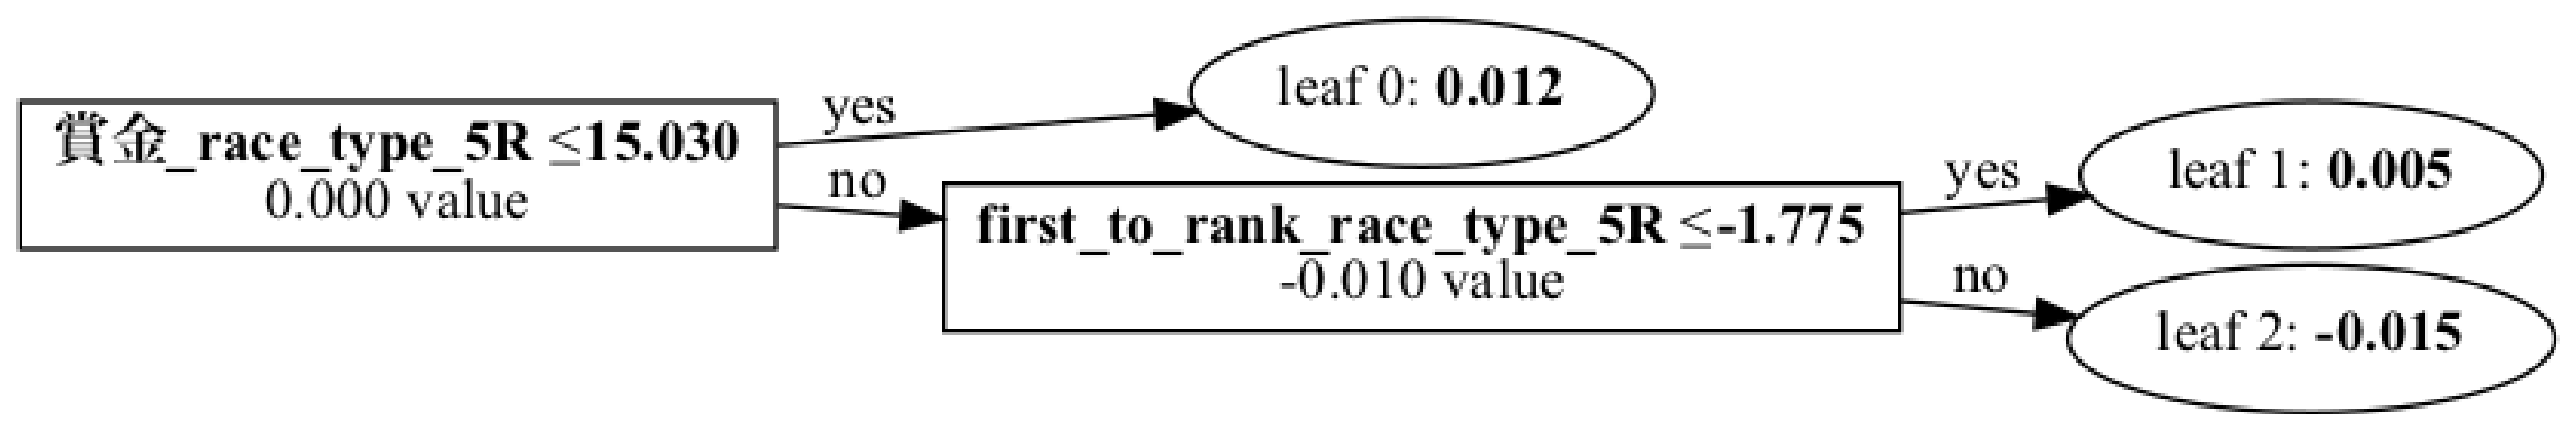

In [82]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [40, 40]
fig, ax = plt.subplots(figsize=(80, 80), facecolor="w")
# 可視化したい木の番号
tree_index = 0 
lgb.plot_tree(
    booster=lgb_rank,
    tree_index=tree_index,
    show_info='internal_value',
    ax=ax 
    )
plt.show()


## 特徴量重要度

In [149]:
funcs.plot_importances(lgb_rank,x_train,n_display=60)

                          features  importances
4                         horse_id         1033
97                          peds_1          386
101                         peds_5          230
157                        peds_61          149
109                        peds_13          131
7                         owner_id          129
125                        peds_29          114
5                        jockey_id          112
6                       trainer_id          112
156                        peds_60          108
124                        peds_28           42
155                        peds_59           40
108                        peds_12           40
13                           賞金_5R           38
100                         peds_4           25
27                 賞金_race_type_5R           23
123                        peds_27           17
153                        peds_57           17
96                          peds_0           17
20                賞金_course_len_5R      

# grid search

In [72]:
processed_df = make_train_data.get_processed_df()

# 訓練用, 検証用, simulation用のデータに分割
x_base,y_base,x_test,y_test = funcs.make_data(processed_df,test_size=0.3)
# test_index_list = x_test.index
x_train,y_train,x_valid,y_valid = funcs.make_data(processed_df.loc[x_base.index],test_size=0.2)

# データ作成
train_query = x_train.groupby(x_train.index).size()
valid_query = x_valid.groupby(x_valid.index).size()

params = {}
params['feature_pre_filter'] = False # <= これしないと, lambda_l1/min_data_in_leaf の学習できない
train = lgb.Dataset(x_train, y_train, group=train_query,params=params, free_raw_data=False)
valid = lgb.Dataset(x_valid, y_valid, reference=train, group=valid_query, params=params, free_raw_data=False)



### hyperopt版

In [98]:
%autoreload

In [ ]:
from hyperopt import Trials

trials = Trials()
best_params = training.optimize(trials,train,valid)
print("-------------------------------------------")
print(best_params )

""" 探索するパラメタは
    
    └─my_modules
        |
        └─training
            └─_tune_hyper_opt.py <= ここに記述してある
    
    追加で探索 or 選択したい特徴量があれば, 適宜記述しなおすこと
"""

### optuna版

In [ ]:

# ---------------- optuna版は探索したい特徴量を適当にセットするだけ ---------

import optuna.integration.lightgbm as lgb_o

lgbm_params = {
        'metric': 'ndcg',
        'objective': 'lambdarank',
        'ndcg_eval_at': [1,2,3],
        'boosting_type': 'gbdt',
        'random_state': 777,
        'force_col_wise':True,
        # ---------- 探索範囲
        'lambdarank_truncation_level': 10,
        'learning_rate': 0.02273417953255777,
        'num_iterations': 100,
        'num_leaves': 42,
        'lambda_l1': 9.59114819426556,
        'lambda_l2': 0.011569741116509751,
        'feature_fraction': 0.7,
        'bagging_fraction': 1.0,
        'bagging_freq': 0,
        'min_data_in_leaf': 20,
}

lgb_rank_o = lgb_o.train(
        lgbm_params,
        train_set=train,
        valid_sets=valid,
        valid_names=['valid'],
        early_stopping_rounds=100
        )

best_params = lgb_rank_o.params
best_params.pop('early_stopping_round')
print(best_params)

# 27 min かかった

In [100]:
best_params

{'colsample_bytree': 0.4705236576332061,
 'lambdarank_truncation_level': 14.0,
 'learning_rate': 0.023174436767163235,
 'min_child_samples': 2.0,
 'reg_alpha': 0.06546289411822655,
 'reg_lambda': 303.4518855514689,
 'subsample': 0.6574504757400097,
 'subsample_freq': 18.0}

In [106]:
for idx,key in enumerate(base_params):
    best_params[key] = base_params[key]

best_params['lambdarank_truncation_level'] = int(best_params['lambdarank_truncation_level'])
best_params['subsample_freq'] = int(best_params['subsample_freq'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

# best_params で 再学習

In [107]:

# best_params で再び学習
lgb_rank = lgb.train(
    best_params,
    train,
    )


In [108]:
funcs.plot_importances(lgb_rank,x_train,n_display=60)

                         features  importances
4                        horse_id          801
97                         peds_1          396
109                       peds_13          193
101                        peds_5          188
7                        owner_id          168
125                       peds_29          159
157                       peds_61          147
156                       peds_60           98
6                      trainer_id           91
5                       jockey_id           82
124                       peds_28           60
155                       peds_59           55
11                        n_horse           52
108                       peds_12           42
100                        peds_4           34
123                       peds_27           33
121                       peds_25           31
96                         peds_0           27
153                       peds_57           23
107                       peds_11           22
55           

# 精度とシミュレーション

In [155]:
%autoreload

In [150]:
test_race_index = list(set(x_test.index))
my_simulator = simulator.Simulator(lgb_rank)
result_df = my_simulator.get_result_df(processed_df.loc[test_race_index],return_tables) # 結構時間かかる

In [152]:
%autoreload

In [153]:
detail_dict = funcs.calc_(
    result_df,
    kaime='tansho',    # 買い方, 'fukusho', 'wide', ... 一通り, 買い方準備した
    odds_alpha=1,      # この閾値以上のオッズだったら買う, どの買い目でも単勝オッズで判断する点に注意
    bet=100,           # 何円賭けるか
    is_all=True,       # 全レースに賭けるか, False なら round_list のレースにしか賭けない
    round_list=['05'], # ここのレース番号に賭ける
    verbose=True       # 可視化するか否か
    )

収益               :       -63430.00 円
平均収益           :          -22.88 円
回収率             :           77.12 %
的中率             :           19.95 %
odds filter 的中率 :           19.95 %
レース数           :            2772
賭けた点数         :               0
race dist {'01': 66, '02': 52, '03': 59, '04': 49, '05': 48, '06': 53, '07': 45, '08': 36, '09': 31, '10': 38, '11': 34, '12': 42}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


## 最適買い目　探索

In [156]:
funcs.show_best_kaime(result_df,'tansho')

---------------------
01
odds_alpha             :             20
best_prf               :       -1300.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          94.37 %
best_accuracy          :           0.00 %
best_filtered_accuracy :           0.00 %
total race_num         :            231
filterd_race_num       :             13
bought_num           :              0
---------------------
02
odds_alpha             :              7
best_prf               :       -1300.00 円
best_mean_prf          :         -22.03 円
best_recovery_rate     :          94.40 %
best_accuracy          :           2.16 %
best_filtered_accuracy :           8.47 %
total race_num         :            232
filterd_race_num       :             59
bought_num           :              0
---------------------
03
odds_alpha             :             15
best_prf               :        5350.00 円
best_mean_prf          :         191.07 円
best_recovery_rate     :         123.06 %
best_accuracy          

In [157]:
%autoreload
funcs.show_best_kaime(result_df,'fukusho')


---------------------
01
odds_alpha             :             13
best_prf               :        -250.00 円
best_mean_prf          :         -11.36 円
best_recovery_rate     :          98.92 %
best_accuracy          :           2.16 %
best_filtered_accuracy :          22.73 %
total race_num         :            231
filterd_race_num       :             22
bought_num             :              0
---------------------
02
odds_alpha             :              7
best_prf               :       -1140.00 円
best_mean_prf          :         -19.32 円
best_recovery_rate     :          95.09 %
best_accuracy          :           7.76 %
best_filtered_accuracy :          30.51 %
total race_num         :            232
filterd_race_num       :             59
bought_num             :              0
---------------------
03
odds_alpha             :             19
best_prf               :        3090.00 円
best_mean_prf          :         147.14 円
best_recovery_rate     :         113.32 %
best_accuracy      

In [158]:
funcs.show_best_kaime(result_df,'wide')


---------------------
01
odds_alpha             :              4
best_prf               :        1980.00 円
best_mean_prf          :          28.29 円
best_recovery_rate     :         108.57 %
best_accuracy          :           4.33 %
best_filtered_accuracy :          14.29 %
total race_num         :            231
filterd_race_num       :             70
bought_num             :              0
---------------------
02
odds_alpha             :              4
best_prf               :        6340.00 円
best_mean_prf          :          84.53 円
best_recovery_rate     :         127.33 %
best_accuracy          :           6.03 %
best_filtered_accuracy :          18.67 %
total race_num         :            232
filterd_race_num       :             75
bought_num             :              0
---------------------
03
odds_alpha             :             17
best_prf               :        -400.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          98.28 %
best_accuracy      

In [159]:

funcs.show_best_kaime(result_df,'umaren')


---------------------
01
odds_alpha             :              4
best_prf               :       16810.00 円
best_mean_prf          :         240.14 円
best_recovery_rate     :         172.77 %
best_accuracy          :           2.16 %
best_filtered_accuracy :           7.14 %
total race_num         :            231
filterd_race_num       :             70
bought_num             :              0
---------------------
02
odds_alpha             :             15
best_prf               :           0.00 円
best_mean_prf          :          -1.00 円
best_recovery_rate     :         100.00 %
best_accuracy          :           0.00 %
best_filtered_accuracy :        -100.00 %
total race_num         :            232
filterd_race_num       :              0
bought_num             :              0
---------------------
03
odds_alpha             :             17
best_prf               :        -400.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          98.28 %
best_accuracy      

In [160]:
%autoreload
funcs.show_best_kaime(result_df,'sanrenpuku_box')


---------------------
01
odds_alpha             :             16
best_prf               :           0.00 円
best_mean_prf          :          -1.00 円
best_recovery_rate     :         100.00 %
best_accuracy          :           0.00 %
best_filtered_accuracy :        -100.00 %
total race_num         :            231
filterd_race_num       :              0
bought_num             :              0
---------------------
02
odds_alpha             :              5
best_prf               :        4000.00 円
best_mean_prf          :         142.86 円
best_recovery_rate     :         117.24 %
best_accuracy          :           0.43 %
best_filtered_accuracy :           3.57 %
total race_num         :            232
filterd_race_num       :             28
bought_num             :             28
---------------------
03
odds_alpha             :              2
best_prf               :        4520.00 円
best_mean_prf          :          25.54 円
best_recovery_rate     :         119.48 %
best_accuracy      

In [161]:

funcs.show_best_kaime(result_df,'umaren_box')

---------------------
01
odds_alpha             :              7
best_prf               :       16290.00 円
best_mean_prf          :         173.30 円
best_recovery_rate     :         170.52 %
best_accuracy          :           0.87 %
best_filtered_accuracy :           2.13 %
total race_num         :            231
filterd_race_num       :             94
bought_num             :             94
---------------------
02
odds_alpha             :             15
best_prf               :           0.00 円
best_mean_prf          :           0.00 円
best_recovery_rate     :         100.00 %
best_accuracy          :           0.00 %
best_filtered_accuracy :           0.00 %
total race_num         :            232
filterd_race_num       :             18
bought_num             :             18
---------------------
03
odds_alpha             :             17
best_prf               :        -600.00 円
best_mean_prf          :         -50.00 円
best_recovery_rate     :          97.41 %
best_accuracy      

In [162]:

funcs.show_best_kaime(result_df,'wide_box')

---------------------
01
odds_alpha             :              7
best_prf               :        -170.00 円
best_mean_prf          :          -1.81 円
best_recovery_rate     :          99.26 %
best_accuracy          :           1.30 %
best_filtered_accuracy :           3.19 %
total race_num         :            231
filterd_race_num       :             94
bought_num             :             94
---------------------
02
odds_alpha             :              5
best_prf               :        6160.00 円
best_mean_prf          :          32.42 円
best_recovery_rate     :         126.55 %
best_accuracy          :           5.17 %
best_filtered_accuracy :           6.32 %
total race_num         :            232
filterd_race_num       :            190
bought_num             :            190
---------------------
03
odds_alpha             :             17
best_prf               :        2080.00 円
best_mean_prf          :         173.33 円
best_recovery_rate     :         108.97 %
best_accuracy      

In [163]:

funcs.show_best_kaime(result_df,'umatan')


---------------------
01
odds_alpha             :              3
best_prf               :        7260.00 円
best_mean_prf          :          50.42 円
best_recovery_rate     :         131.43 %
best_accuracy          :           3.90 %
best_filtered_accuracy :           6.25 %
total race_num         :            231
filterd_race_num       :            144
bought_num             :              0
---------------------
02
odds_alpha             :             20
best_prf               :       -1800.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          92.24 %
best_accuracy          :           0.00 %
best_filtered_accuracy :           0.00 %
total race_num         :            232
filterd_race_num       :             18
bought_num             :              0
---------------------
03
odds_alpha             :             19
best_prf               :       -2100.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          90.95 %
best_accuracy      

In [164]:

funcs.show_best_kaime(result_df,'sanrentan')


---------------------
01
odds_alpha             :             20
best_prf               :       -1300.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          94.37 %
best_accuracy          :           0.00 %
best_filtered_accuracy :           0.00 %
total race_num         :            231
filterd_race_num       :             13
bought_num             :              0
---------------------
02
odds_alpha             :             20
best_prf               :       -1800.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          92.24 %
best_accuracy          :           0.00 %
best_filtered_accuracy :           0.00 %
total race_num         :            232
filterd_race_num       :             18
bought_num             :              0
---------------------
03
odds_alpha             :             19
best_prf               :       -2100.00 円
best_mean_prf          :        -100.00 円
best_recovery_rate     :          90.95 %
best_accuracy      

In [165]:


funcs.show_best_kaime(result_df,'sanrenpuku')


---------------------
01
odds_alpha             :             16
best_prf               :           0.00 円
best_mean_prf          :          -1.00 円
best_recovery_rate     :         100.00 %
best_accuracy          :           0.00 %
best_filtered_accuracy :        -100.00 %
total race_num         :            231
filterd_race_num       :              0
bought_num             :              0
---------------------
02
odds_alpha             :              5
best_prf               :        4000.00 円
best_mean_prf          :         142.86 円
best_recovery_rate     :         117.24 %
best_accuracy          :           0.43 %
best_filtered_accuracy :           3.57 %
total race_num         :            232
filterd_race_num       :             28
bought_num             :              0
---------------------
03
odds_alpha             :              2
best_prf               :        4520.00 円
best_mean_prf          :          25.54 円
best_recovery_rate     :         119.48 %
best_accuracy      

# race 前日準備

In [ ]:
# race_id を取得
race_id_list = prepare.scrape_race_id_list(['20230305']) # <= yyyymmdd で開催されるレースの日付を入力

#出走するhorse_idの取得
horse_id_list = prepare.scrape_horse_id_list(race_id_list)



In [113]:
# race_results データ収集
new_race_results = prepare.scrape_race_results(race_id_list)
# データ更新
race__results = pd.read_csv(LocalPaths.RESULTS_PATH,index_col=0)
update_race_results = funcs.update_data(race_results,new_race_results)
update_race_results.to_csv(LocalPaths.RESULTS_PATH)

In [114]:
# horse_results データ収集
new_horse_results = prepare.scrape_horse_results(horse_id_list)
# データ更新
horse_results = pd.read_csv(LocalPaths.HORSE_RESULTS_PATH,index_col=0)
update_horse_results = funcs.update_data(horse_results,new_horse_results)
update_horse_results.to_csv(LocalPaths.HORSE_RESULTS_PATH)

In [ ]:
# peds データ収集
new_peds = prepare.scrape_peds(horse_id_list)
# データ更新
peds = pd.read_csv(LocalPaths.PEDS_PATH,index_col=0)
update_peds = funcs.update_data(peds,new_peds)
update_peds.to_csv(LocalPaths.PEDS_PATH)

In [ ]:
# データ更新
race_results = pd.read_csv(LocalPaths.RESULTS_PATH,index_col=0)
horse_results = pd.read_csv(LocalPaths.HORSE_RESULTS_PATH,index_col=0)
peds = pd.read_csv(LocalPaths.PEDS_PATH,index_col=0)
peds.fillna('nan',inplace=True) # 何回やってもロードすると, nanが出る
return_tables = pd.read_csv(LocalPaths.RETURN_PATH,index_col=0)
return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)# 毎回読み込むごとに, strに変換されてしまう

In [ ]:
# -------前処理
race_results_processor = preprocess.RaceResults(race_results)
horse_results_processor = preprocess.HorseResults(horse_results)
peds_processor = preprocess.Peds(peds) # <= 結構時間かかる

race_results_processor.preprocessing()
horse_results_processor.preprocessing()
peds_processor.preprocessing()

# -------データマージ
data_merger = preprocess.DataMerger(
    race_results_processor,
    horse_results_processor,
    peds_processor
)
data_merger.merge()

# -------訓練データ作成
make_train_data = preprocess.MakeTrainData(data_merger)
make_train_data.categorize_id()
make_train_data.categorize_peds()
make_train_data.dumminize() 
make_train_data.add_date_cosin()
processed_df = make_train_data.get_processed_df()



finish regularize



--finish categorize id--
--finish categorize peds--
--finish dumminize--


# AI 作成

In [ ]:
processed_df = make_train_data.get_processed_df()
processed_df['rank'].head()

202306010111    10
202306010111     5
202306010111     3
202306010111     0
202306010111     0
Name: rank, dtype: int64

In [ ]:
processed_df = make_train_data.get_processed_df()
processed_df = funcs.change_answer_label(processed_df,label_type='bias_top3')
# 新馬のカテゴリ変数も学習に使いたいので, 訓練データを100%使う
x_train,y_train,_,_ = funcs.make_data(processed_df,test_size=0)

train_query = x_train.groupby(x_train.index).size()
params = {}
params['feature_pre_filter'] = False # <= これしないと, lambda_l1/min_data_in_leaf の学習できない
train_set = lgb.Dataset(x_train, y_train, group=train_query,params=params)

lgbm_params = {
        'metric': 'ndcg',          # 評価指標  
        'objective': 'lambdarank', # ランク学習
        'ndcg_eval_at': [1,2,3],   # 上位3着を考慮
        'boosting_type': 'gbdt',   # gradient based dicision tree
        'random_state': 777,       # 乱数 seed 固定
        'force_col_wise':True,     # cpu だとメモリ効率が良くなるらしい
        'verbosity':-1             # マイナスで, 非表示
            }

# ------------注意事項------------
#  valid_set 入れていると, 1本目の木作成時に過学習扱いされて, そこで学習停止してしまうので注意
#  valid_set は grid search の時だけでいい?

lgb_rank = lgb.train(
    # lgbm_params,
    best_params, # <= 最適 params をセット
    train,
    )

In [ ]:
funcs.plot_importances(lgb_rank, x_train,n_display=60)

                           features  importances
4                          horse_id         2106
7                          owner_id          293
6                        trainer_id          179
5                         jockey_id          126
13                            賞金_5R           35
27                  賞金_race_type_5R           25
34                         賞金_開催_5R           16
12                            着順_5R           13
20                 賞金_course_len_5R           11
9                                体重            9
10                             体重変化            8
90                       賞金_開催_allR            8
14                            着差_5R            8
41                            賞金_9R            7
19                 着順_course_len_5R            7
26                  着順_race_type_5R            7
54                  着順_race_type_9R            7
82                着順_race_type_allR            6
28                  着差_race_type_5R            6
35                  

# 当日予測 (特徴量に 体重データ使ってない場合)

In [166]:
target_race_id_list, target_race_time_list = prepare.scrape_race_id_race_time_list('20230305')

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache


getting race_id_list
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20230305


In [168]:
%autoreload

In [178]:
today = '2023/03/05'
X_list = []
data_c_list = []

for race_id, race_time in zip(target_race_id_list,target_race_time_list):
    
    try:
        #------出馬表をスクレイピング
        shutuba_data = prepare.scrape_shutuba_table(race_id, today)

        #------出馬表データ前処理
        shutuba_processeor = preprocess.ShutubaData(shutuba_data,race_results)
        shutuba_processeor.preprocessing()

        #-------出馬表データマージ
        shutuba_data_merger = preprocess.DataMerger(
            shutuba_processeor,
            horse_results_processor,
            peds_processor
        )
        shutuba_data_merger.merge()

        #-------lgb入力用データ作成
        COLUMNS = x_train.columns
        predict_data = preprocess.MakePredictData(shutuba_data_merger,COLUMNS)
        # 訓練時の　label_encoder で各種カテゴリデータをラベルエンコーディングする
        predict_data.set_lable_encoder(
            make_train_data.le_horse,
            make_train_data.le_jockey,
            make_train_data.le_trainer,
            make_train_data.le_owner,
            make_train_data.le_peds_dict 
        )
        predict_data.categorize_id()
        predict_data.categorize_peds()
        predict_data.dumminize() 
        predict_data.add_date_cosin() 
        processed_df = predict_data.get_processed_df()


        # data_c : simulation用データ
        data_c = processed_df.copy()
        X = processed_df.drop(['単勝'],axis=1)
        X = pd.DataFrame(X,columns=COLUMNS)
        X_list.append(X)
        



        #-------予測
        scores = pd.Series(lgb_rank.predict(X),index=X.index)
        pred = X[['馬番']].copy()
        pred['scores'] = scores
        pred = pred.sort_values('scores',ascending=False)
        
        #--------当日データ検証用
        X['単勝'] = data_c['単勝']
        data_c_list.append(X)

        i=0
        for num in list(Master.PLACE_DICT.values()):
            if num == race_id[4:6]:
                print(list(Master.PLACE_DICT)[i]+race_id[10:12] + 'R ' + race_time + '発走 ' )
                break
            i+=1
        print(pred)
    except Exception as e:
        print("race_id :",race_id)
        print(e)

    time.sleep(5)
    

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山01R 10:05発走 
              馬番    scores
202306020401  16 -0.754086
202306020401  15 -0.861880
202306020401   3 -1.329538
202306020401  12 -1.565889
202306020401   8 -1.749815
202306020401   5 -1.803284
202306020401   2 -2.306572
202306020401   6 -2.950677
202306020401  13 -3.553234
202306020401  14 -3.613767
202306020401   1 -3.666560
202306020401  10 -3.878418
202306020401   7 -4.034802
202306020401   9 -4.154068
202306020401   4 -4.243221
202306020401  11 -4.424635




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202306020402
y contains previously unseen labels: 'エアワルツ'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山03R 11:05発走 
              馬番    scores
202306020403   7  0.166938
202306020403   6 -0.240287
202306020403   5 -0.388510
202306020403   4 -0.702889
202306020403   1 -1.625753
202306020403  11 -1.828944
202306020403  15 -2.167359
202306020403   9 -2.222964
202306020403   3 -2.243160
202306020403  12 -2.297608
202306020403  14 -2.553185
202306020403  10 -2.574687
202306020403   8 -2.876252
202306020403   2 -2.977180
202306020403  13 -3.055340
202306020403  16 -3.648861




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山04R 11:35発走 
              馬番    scores
202306020404   9 -1.046115
202306020404   3 -1.259968
202306020404  12 -1.321917
202306020404  14 -1.409575
202306020404  13 -1.517029
202306020404   1 -1.589498
202306020404  16 -1.741507
202306020404  10 -1.788161
202306020404   5 -1.834077
202306020404   8 -2.066710
202306020404   6 -2.490072
202306020404  11 -2.730744
202306020404  15 -2.858027
202306020404   2 -3.286275
202306020404   4 -3.454040
202306020404   7 -4.222931




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202306020405
y contains previously unseen labels: 'フィーユドノワール'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202306020406
y contains previously unseen labels: 'キョウエイポズナン'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山07R 13:25発走 
              馬番    scores
202306020407  13  0.243466
202306020407  11  0.206192
202306020407  12 -0.639597
202306020407   1 -0.697333
202306020407   7 -0.919391
202306020407  15 -0.924877
202306020407   3 -1.022353
202306020407   5 -1.458606
202306020407  14 -1.472548
202306020407  16 -1.574363
202306020407  10 -1.582571
202306020407   6 -1.912202
202306020407   2 -2.844086
202306020407   4 -2.978621
202306020407   8 -3.497340
202306020407   9 -3.661795




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山08R 14:01発走 
              馬番    scores
202306020408   3  1.086436
202306020408  14  0.493928
202306020408   6  0.140609
202306020408   8 -0.472345
202306020408   2 -0.501701
202306020408  12 -0.923274
202306020408  10 -0.958904
202306020408  13 -1.128231
202306020408   1 -1.178857
202306020408  15 -1.350144
202306020408   7 -1.403316
202306020408  11 -1.563657
202306020408   5 -1.578877
202306020408   9 -2.110780
202306020408   4 -2.216712




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山09R 14:35発走 
              馬番    scores
202306020409   7  0.810890
202306020409   5  0.302990
202306020409  11  0.210947
202306020409  10 -0.089637
202306020409  12 -0.146025
202306020409   3 -0.322857
202306020409   9 -0.586730
202306020409   6 -0.634181
202306020409  13 -0.722808
202306020409  16 -0.885649
202306020409  17 -1.129577
202306020409   2 -1.155759
202306020409  14 -1.222252
202306020409  18 -1.335366
202306020409   8 -1.660144
202306020409  15 -1.706202
202306020409   4 -1.709481
202306020409   1 -2.757771




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山10R 15:10発走 
              馬番    scores
202306020410  10  0.750567
202306020410  12  0.336816
202306020410  16  0.324089
202306020410   3  0.035340
202306020410  11 -0.018404
202306020410  14 -0.056825
202306020410  13 -0.291135
202306020410   6 -0.425906
202306020410   8 -1.483652
202306020410   9 -1.504676
202306020410   4 -1.859225
202306020410   7 -1.985147
202306020410   5 -2.152367
202306020410   2 -2.858990
202306020410   1 -3.527332
202306020410  15 -3.747883




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202306020411
y contains previously unseen labels: 'パルティトゥーラ'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
中山12R 16:25発走 
              馬番    scores
202306020412  12 -0.073567
202306020412   9 -0.200929
202306020412  14 -0.353280
202306020412  10 -0.375890
202306020412   3 -0.708663
202306020412  13 -0.885448
202306020412   5 -0.913827
202306020412   8 -1.221259
202306020412  16 -1.265633
202306020412   6 -1.279780
202306020412   4 -1.388257
202306020412   1 -1.394082
202306020412   2 -1.469388
202306020412  15 -1.629666
202306020412   7 -2.207558
202306020412  11 -2.520821




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神01R 09:50発走 
              馬番    scores
202309010801   6 -1.283674
202309010801   8 -1.291264
202309010801  14 -1.424385
202309010801   7 -1.428214
202309010801   1 -2.052975
202309010801  11 -2.141213
202309010801   2 -2.234423
202309010801   4 -2.350393
202309010801  13 -2.364852
202309010801   5 -2.482201
202309010801  10 -2.643696
202309010801  15 -2.770409
202309010801   3 -2.794724
202309010801   9 -3.417422
202309010801  12 -4.606130




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202309010802
y contains previously unseen labels: 'エレメンツ'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202309010803
y contains previously unseen labels: 'レゲウーマン'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神04R 11:20発走 
              馬番    scores
202309010804   4 -0.176545
202309010804   2 -0.617407
202309010804   9 -0.869622
202309010804   8 -1.156049
202309010804   6 -1.205013
202309010804   7 -1.219765
202309010804   1 -1.513204
202309010804  10 -2.068644
202309010804   3 -2.515973
202309010804   5 -2.800396




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202309010805
y contains previously unseen labels: 'ハコダテダリア'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神06R 12:40発走 
              馬番    scores
202309010806   1 -1.003899
202309010806   9 -1.105054
202309010806   7 -1.184775
202309010806   8 -1.679978
202309010806   5 -1.859237
202309010806   4 -2.040967
202309010806   3 -2.108642
202309010806   6 -3.337414
202309010806   2 -3.378682




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神07R 13:15発走 
              馬番    scores
202309010807   6 -0.036734
202309010807  11 -0.650420
202309010807  14 -0.753021
202309010807  15 -0.860514
202309010807  16 -1.102953
202309010807   4 -1.132184
202309010807   8 -1.298670
202309010807   7 -1.536912
202309010807   5 -1.777177
202309010807   3 -1.819180
202309010807  12 -2.225872
202309010807   9 -2.572188
202309010807  10 -2.738052
202309010807   2 -2.841786
202309010807  17 -2.869956
202309010807  13 -2.999504
202309010807   1 -3.346892




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
race_id : 202309010808
y contains previously unseen labels: 'スターオブロゼッタ'




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神09R 14:25発走 
              馬番    scores
202309010809   5  0.369978
202309010809   8  0.005565
202309010809   3 -0.449259
202309010809   7 -0.724720
202309010809   1 -0.988082
202309010809   9 -1.001115
202309010809   6 -1.530473
202309010809  10 -1.633786
202309010809   4 -1.713404
202309010809   2 -1.718243
202309010809  11 -1.746994
202309010809  12 -2.153350




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神10R 15:01発走 
              馬番    scores
202309010810   8 -0.044267
202309010810   3 -0.574168
202309010810   2 -0.845531
202309010810  10 -1.183331
202309010810   7 -1.201678
202309010810   5 -1.284695
202309010810   4 -1.390492
202309010810   9 -1.692341
202309010810   1 -2.058875
202309010810   6 -2.172067




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神11R 15:35発走 
              馬番    scores
202309010811   4  0.663103
202309010811   7  0.568877
202309010811  16  0.497141
202309010811   6  0.323164
202309010811  15 -0.019735
202309010811  13 -0.118199
202309010811   1 -0.328411
202309010811   9 -0.416667
202309010811  11 -0.511280
202309010811   8 -0.926376
202309010811  10 -1.010458
202309010811  14 -1.119745
202309010811   5 -2.227013
202309010811   3 -2.369974
202309010811   2 -2.418918
202309010811  12 -2.707379




[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 110.0.5481
[WDM] - Get LATEST driver version for 110.0.5481
[WDM] - Driver [/Users/rince/.wdm/drivers/chromedriver/mac64/110.0.5481.77/chromedriver] found in cache



--finish categorize id--
--finish categorize peds--
--finish dumminize--
--finish add cosin--
阪神12R 16:10発走 
              馬番    scores
202309010812  12  0.424995
202309010812   1 -0.092918
202309010812   7 -0.285946
202309010812  15 -0.343224
202309010812   4 -0.514815
202309010812   3 -0.584244
202309010812   9 -0.608403
202309010812  14 -0.856433
202309010812   6 -0.866457
202309010812   2 -1.490800
202309010812   8 -1.527342
202309010812  10 -1.556607
202309010812  13 -1.720696
202309010812  11 -1.746237
202309010812  16 -1.882470
202309010812   5 -1.919368


# 当日データのsimulation

In [179]:
#------エラーでたrace対策
target_race_id_list = []
for data_c in data_c_list:
    race_id = data_c.index[0]
    target_race_id_list.append(race_id)

In [180]:
ts = simulator.TodaySimulator(lgb_rank)
return_table_today = ts.return_table_today(target_race_id_list)
result_df_today_rank = ts.get_result_df(data_c_list, return_table_today, target_race_id_list)


In [193]:
result_df_today_rank

,pred_list,actual_rank_list,tansho_odds,fukusho_odds,umaren_odds,wide_odds,umatan_odds,sanrenpuku_odds,sanrentan_odds,wide_comb,odds_list
202306020401,"[16, 15, 3, 12, 8, 5, 2, 6, 13, 14, 1, 10, 7, ...","[3, 1, 8]",10,"[5.1, 32.0, 7.6]",282.9,"[53.3, 12.4, 96.9]",579.9,910.6,5282.3,"[[1, 3], [3, 8], [1, 8]]","[1.5, 245.5, 10.0, 5.3, 15.0, 40.2, 35.7, 30.5..."
202306020403,"[7, 6, 5, 4, 1, 11, 15, 9, 3, 12, 14, 10, 8, 2...","[12, 6, 4]",6,"[1.8, 1.4, 8.0]",8.1,"[3.9, 31.2, 20.8]",20.4,89,415.8,"[[6, 12], [4, 12], [4, 6]]","[3.4, 2.7, 49.6, 54.9, 33.6, 5.0, 152.8, 44.9,..."
202306020404,"[9, 3, 12, 14, 13, 1, 16, 10, 5, 8, 6, 11, 15,...","[16, 9, 13]",7,"[2.1, 1.4, 3.1]",9.8,"[3.7, 16.1, 7.7]",22.9,52.6,215.1,"[[9, 16], [13, 16], [9, 13]]","[2.4, 5.8, 67.9, 73.0, 21.8, 30.1, 7.0, 8.1, 1..."
202306020407,"[13, 11, 12, 1, 7, 15, 3, 5, 14, 16, 10, 6, 2,...","[3, 12, 7]",27.1,"[6.7, 2.4, 4.6]",71.4,"[21.1, 36.2, 15.0]",186.4,244.8,1524.7,"[[3, 12], [3, 7], [7, 12]]","[4.3, 2.5, 5.2, 8.3, 14.5, 55.8, 27.1, 66.4, 4..."
202306020408,"[3, 14, 6, 8, 2, 12, 10, 13, 1, 15, 7, 11, 5, ...","[5, 6, 7]",3.6,"[1.6, 3.1, 3.1]",18,"[7.5, 7.4, 16.2]",32.1,56.1,253.3,"[[5, 6], [5, 7], [6, 7]]","[14.5, 224.2, 10.7, 7.1, 4.4, 38.5, 16.3, 42.4..."
202306020409,"[7, 5, 11, 10, 12, 3, 9, 6, 13, 16, 17, 2, 14,...","[14, 7, 12]",3.5,"[1.5, 1.5, 2.4]",9.4,"[4.0, 5.3, 9.4]",17.2,21.6,72.2,"[[7, 14], [12, 14], [7, 12]]","[4.5, 10.4, 85.6, 18.5, 7.7, 7.5, 117.3, 7.0, ..."
202306020410,"[10, 12, 16, 3, 11, 14, 13, 6, 8, 9, 4, 7, 5, ...","[13, 9, 3]",5.4,"[1.7, 1.4, 1.9]",9,"[3.9, 6.7, 3.6]",20.9,15,89.8,"[[9, 13], [3, 13], [3, 9]]","[17.8, 29.3, 17.4, 5.9, 4.3, 15.9, 5.4, 43.6, ..."
202306020412,"[12, 9, 14, 10, 3, 13, 5, 8, 16, 6, 4, 1, 2, 1...","[7, 12, 3]",7,"[2.5, 1.3, 4.8]",8.1,"[4.1, 34.9, 10.8]",23.7,78.6,437.5,"[[7, 12], [3, 7], [3, 12]]","[1.9, 32.2, 8.7, 121.1, 24.9, 6.7, 68.3, 64.8,..."
202309010801,"[6, 8, 14, 7, 1, 11, 2, 4, 13, 5, 10, 15, 3, 9...","[8, 7, 15]",1.6,"[1.1, 2.8, 2.0]",11.4,"[5.3, 4.5, 14.7]",16.1,35.3,111.2,"[[7, 8], [8, 15], [7, 15]]","[4.7, 1.6, 38.4, 14.2, 283.4, 35.4, 31.3, 140...."
202309010804,"[4, 2, 9, 8, 6, 7, 1, 10, 3, 5]","[1, 6, 10]",12.7,"[3.8, 12.7, 9.0]",160.7,"[46.3, 28.0, 71.1]",291.3,781.5,4480.3,"[[1, 6], [1, 10], [6, 10]]","[21.0, 2.4, 2.7, 12.2, 58.2, 6.3, 12.7, 33.4, ..."


In [185]:
detail_dict_tansho  = funcs.calc_(result_df_today_rank,kaime='tansho',odds_alpha=1,is_all=True,round_list=['01'])


収益               :        -1600.00 円
平均収益           :         -100.00 円
回収率             :            0.00 %
的中率             :            0.00 %
odds filter 的中率 :            0.00 %
レース数           :              16
賭けた点数         :               0
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 0, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [181]:

detail_dict_fukusho  = funcs.calc_(result_df_today_rank,kaime='fukusho',odds_alpha=1,is_all=True,round_list=['12'])

収益               :         -450.00 円
平均収益           :          -28.12 円
回収率             :           71.88 %
的中率             :           37.50 %
odds filter 的中率 :           37.50 %
レース数           :              16
賭けた点数         :               0
race dist {'01': 0, '02': 0, '03': 0, '04': 1, '05': 0, '06': 0, '07': 1, '08': 0, '09': 2, '10': 0, '11': 0, '12': 2}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [182]:
detail_dict_wide  = funcs.calc_(result_df_today_rank,kaime='wide',odds_alpha=1,is_all=True,round_list=['01'])

収益               :         3620.00 円
平均収益           :          226.25 円
回収率             :          326.25 %
的中率             :            6.25 %
odds filter 的中率 :            6.25 %
レース数           :              16
賭けた点数         :               0
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 1, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [186]:
detail_dict_wide_box  = funcs.calc_(result_df_today_rank,kaime='wide_box',odds_alpha=1,is_all=True,round_list=['01'],num_buy=3)

収益               :          420.00 円
平均収益           :            8.75 円
回収率             :          126.25 %
的中率             :            6.25 %
odds filter 的中率 :            2.08 %
賭けた点数の回収率 :          108.75 %
賭けた点数の的中率 :            2.08 %
レース数           :              16
賭けた点数         :              48
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 1, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [187]:
# バケモノ馬連当ててる
detail_dict_umaren  = funcs.calc_(result_df_today_rank,kaime='umaren',odds_alpha=1,is_all=True,round_list=['01'])

収益               :        18060.00 円
平均収益           :         1128.75 円
回収率             :         1228.75 %
的中率             :            6.25 %
odds filter 的中率 :            6.25 %
レース数           :              16
賭けた点数         :               0
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 1, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [188]:

detail_dict_umatan  = funcs.calc_(result_df_today_rank,kaime='umatan',odds_alpha=1,is_all=True,round_list=['01'])

収益               :        -1600.00 円
平均収益           :         -100.00 円
回収率             :            0.00 %
的中率             :            0.00 %
odds filter 的中率 :            0.00 %
レース数           :              16
賭けた点数         :               0
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 0, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [189]:

detail_dict_umaren_box  = funcs.calc_(result_df_today_rank,kaime='umaren_box',odds_alpha=1,is_all=True,round_list=['01'],num_buy=3)

収益               :        14860.00 円
平均収益           :          309.58 円
回収率             :         1028.75 %
的中率             :            6.25 %
odds filter 的中率 :            2.08 %
賭けた点数の回収率 :          409.58 %
賭けた点数の的中率 :            2.08 %
レース数           :              16
賭けた点数         :              48
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 1, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [190]:

detail_dict_sanrenpuku  = funcs.calc_(result_df_today_rank,kaime='sanrenpuku',odds_alpha=1,is_all=True,round_list=['01'])

収益               :        -1600.00 円
平均収益           :         -100.00 円
回収率             :            0.00 %
的中率             :            0.00 %
odds filter 的中率 :            0.00 %
レース数           :              16
賭けた点数         :               0
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 0, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [191]:

detail_dict_sanrenpuku_box  = funcs.calc_(result_df_today_rank,kaime='sanrenpuku_box',odds_alpha=1,is_all=True,round_list=['01'],num_buy=6)

収益               :        -6730.00 円
平均収益           :          -21.03 円
回収率             :         -320.62 %
的中率             :            6.25 %
odds filter 的中率 :            0.31 %
賭けた点数の回収率 :           78.97 %
賭けた点数の的中率 :            0.31 %
レース数           :              16
賭けた点数         :             320
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 1, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


In [192]:

detail_dict_sanrentan  = funcs.calc_(result_df_today_rank,kaime='sanrentan',odds_alpha=1,is_all=True,round_list=['01'])

収益               :        -1600.00 円
平均収益           :         -100.00 円
回収率             :            0.00 %
的中率             :            0.00 %
odds filter 的中率 :            0.00 %
レース数           :              16
賭けた点数         :               0
race dist {'01': 0, '02': 0, '03': 0, '04': 0, '05': 0, '06': 0, '07': 0, '08': 0, '09': 0, '10': 0, '11': 0, '12': 0}
race type dist {'new_horse': 0, 'not_win': 0, 'won1': 0, 'won2': 0, 'won3': 0, 'open': 0, 'g1': 0, 'g2': 0, 'g3': 0, 'obstacle': 0}


# 当日予測 (特徴量に体重データ使っている場合)